In [2]:
# # Pretrain MIM with 2D U-Net on STS-2D-Tooth
#
# This notebook performs self-supervised pretraining on all 2D X-ray images
# using a Masked Image Modeling (MIM) / Masked Autoencoder-style objective
# with a 2D U-Net backbone.
#
# Pipeline:
# 1. Load the preprocessed index (`sts2d_index.csv`) and build `df_pretrain`
#    (all non-mask images, ~4000 samples).
# 2. Define a light augmentation pipeline for MIM pretraining.
# 3. Define a `DentalMIMReconstructionDataset`:
#      - loads an image
#      - applies augmentation
#      - generates random block masks on the image
#      - returns (masked_image, target_image, mask, meta)
# 4. Define a small 2D U-Net model.
# 5. Train the U-Net to reconstruct the original image from the masked image,
#    with the loss computed mainly on masked regions (MIM-style).
# 6. Save the pretrained U-Net weights to disk for later segmentation fine-tuning.

In [3]:
# %%
import os
from pathlib import Path
import random

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import matplotlib.pyplot as plt

# Make plots inline if you are in Jupyter
# %matplotlib inline

# -----------------------------
# Reproducibility
# -----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# -----------------------------
# Paths (aligned with data_enhance.ipynb)
# -----------------------------
DATA_ROOT = Path("./sts_tooth_data").resolve()
PROCESSED_2D_DIR = DATA_ROOT / "processed_2d"
INDEX_CSV = DATA_ROOT / "sts2d_index.csv"

print("DATA_ROOT      :", DATA_ROOT)
print("PROCESSED_2D   :", PROCESSED_2D_DIR)
print("INDEX_CSV path :", INDEX_CSV)

# -----------------------------
# Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

D:\Tool\Anaconda3\envs\dlcv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DATA_ROOT      : E:\Data\ToothSeg\sts_tooth_data
PROCESSED_2D   : E:\Data\ToothSeg\sts_tooth_data\processed_2d
INDEX_CSV path : E:\Data\ToothSeg\sts_tooth_data\sts2d_index.csv
Using device: cuda


In [4]:
# ## 2. Load index and build `df_pretrain`
#
# - We load `sts2d_index.csv` generated in `preprocessing.ipynb` / `data_enhance.ipynb`.
# - Each row corresponds to a PNG file with:
#     * rel_path
#     * age_group
#     * label_status
#     * is_mask
#     * pair_id
# - For MIM pretraining, we only need non-mask images (`is_mask == False`).

# %%
assert INDEX_CSV.exists(), f"Index CSV not found: {INDEX_CSV}"

df = pd.read_csv(INDEX_CSV)
print("Full index shape:", df.shape)
print(df.head())

# Split into images vs masks
df_img = df[df["is_mask"] == False].copy()
df_mask = df[df["is_mask"] == True].copy()

print("\nNumber of image rows:", len(df_img))
print("Number of mask rows :", len(df_mask))

# For MIM pretraining, we use ALL non-mask images
df_pretrain = df_img.reset_index(drop=True)
print("\nPretraining dataframe shape:", df_pretrain.shape)

print("\nValue counts — age_group:")
print(df_pretrain["age_group"].value_counts())

print("\nValue counts — label_status:")
print(df_pretrain["label_status"].value_counts())


Full index shape: (4900, 5)
                          rel_path age_group label_status  is_mask  pair_id
0  A-PXI/Labeled/Image/A_L_001.png     adult      labeled    False  a_l_001
1  A-PXI/Labeled/Image/A_L_002.png     adult      labeled    False  a_l_002
2  A-PXI/Labeled/Image/A_L_003.png     adult      labeled    False  a_l_003
3  A-PXI/Labeled/Image/A_L_004.png     adult      labeled    False  a_l_004
4  A-PXI/Labeled/Image/A_L_005.png     adult      labeled    False  a_l_005

Number of image rows: 4000
Number of mask rows : 900

Pretraining dataframe shape: (4000, 5)

Value counts — age_group:
age_group
adult       3500
children     500
Name: count, dtype: int64

Value counts — label_status:
label_status
unlabeled    3100
labeled       900
Name: count, dtype: int64


In [5]:
# ## 3. Helper functions
#
# We reuse the same logic as in `data_enhance.ipynb` to map index rows to
# actual file paths under `processed_2d/`, and to load grayscale images.
#
# Folder structure (from preprocessing):
#   processed_2d/
#       adult/
#         labeled/
#           images/
#           masks/
#         unlabeled/
#           images/
#       children/
#         ...
# %%
def get_image_path_from_row(row: pd.Series) -> Path:
    """
    Map a row from df_pretrain to a local image path in processed_2d.

    We ignore the original `rel_path` subfolder structure and use:
        processed_2d / age_group / label_status / images / <filename>

    For example:
      rel_path = "A-PXI/Labeled/Image/A_L_001.png"
      age_group = "adult"
      label_status = "labeled"

    -> processed_2d/adult/labeled/images/A_L_001.png
    """
    rel = Path(row["rel_path"])
    age_group = row["age_group"]
    label_status = row["label_status"]

    # Handle potential "unknown" but in df_pretrain it should be adult/children + labeled/unlabeled
    if age_group not in ("adult", "children"):
        age_group = "unknown"
    if label_status not in ("labeled", "unlabeled"):
        label_status = "unknown"

    img_path = PROCESSED_2D_DIR / age_group / label_status / "images" / rel.name
    return img_path


def load_image_as_array(path: Path) -> np.ndarray:
    """
    Load a PNG as a grayscale numpy array of shape (H, W), dtype uint8.

    We do NOT normalize or resize here. That will be handled by Albumentations.
    """
    if not path.exists():
        raise FileNotFoundError(f"Image file not found: {path}")
    img = Image.open(path).convert("L")  # "L" = single-channel grayscale
    return np.array(img)


# Quick sanity check: try loading one random image
sample_row = df_pretrain.sample(1, random_state=SEED).iloc[0]
sample_path = get_image_path_from_row(sample_row)
sample_img = load_image_as_array(sample_path)
print("Sample image path:", sample_path)
print("Sample image shape:", sample_img.shape)


Sample image path: E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\images\A_L_556.png
Sample image shape: (320, 640)


In [6]:
# ## 4. Light augmentation for MIM pretraining
#
# We define a mild augmentation pipeline:
# - Resize to a fixed size (320 x 640)
# - Random horizontal flip
# - Small rotation (to simulate slightly different acquisition angles)
# - Mild brightness/contrast jitter
# - Mild Gaussian noise and blur
# - Normalize to mean=0.5, std=0.25 and convert to PyTorch tensor
#
# Important:
# - We do *not* perform aggressive cropping or cutout here.
# - Masking (MIM) will be handled separately by our Dataset.
# %%
TARGET_HEIGHT = 320
TARGET_WIDTH = 640

def get_mim_pretrain_transform() -> A.Compose:
    return A.Compose(
        [
            A.Resize(height=TARGET_HEIGHT, width=TARGET_WIDTH),
            A.HorizontalFlip(p=0.5),
            A.Rotate(
                limit=5,
                border_mode=cv2.BORDER_REFLECT_101,
                p=0.5,
            ),
            A.RandomBrightnessContrast(
                brightness_limit=0.1,
                contrast_limit=0.1,
                p=0.5,
            ),
            A.GaussNoise(p=0.2),
            A.GaussianBlur(blur_limit=(3, 5), p=0.2),
            A.ToFloat(max_value=255.0),
            A.Normalize(mean=(0.5,), std=(0.25,)),
            ToTensorV2(),
        ]
    )

mim_transform = get_mim_pretrain_transform()
print("MIM pretrain transform created.")

MIM pretrain transform created.


In [7]:
# ## 5. Random block mask generator
#
# For MIM-style pretraining with a 2D U-Net, we will:
# - Work in pixel space (H, W), not in token space.
# - Generate random block masks on the *image plane*:
#     * Each mask is a rectangle with random size and position.
#     * The union of all rectangles forms the final mask.
# - The model will see the masked image and try to reconstruct the original.
#
# The function below creates a binary mask of shape (H, W) where:
#   mask[y, x] = 1.0 means "this pixel is masked (to be reconstructed)".
# %%

def random_block_mask(
    height: int,
    width: int,
    num_blocks: int = 8,
    min_block_fraction: float = 0.1,
    max_block_fraction: float = 0.3,
) -> np.ndarray:
    """
    Generate a random block mask (H, W) in {0.0, 1.0},
    where 1.0 = masked pixel.
    """
    mask = np.zeros((height, width), dtype=np.float32)

    for _ in range(num_blocks):
        block_h = int(np.random.uniform(min_block_fraction, max_block_fraction) * height)
        block_w = int(np.random.uniform(min_block_fraction, max_block_fraction) * width)

        block_h = max(1, min(block_h, height))
        block_w = max(1, min(block_w, width))

        y1 = np.random.randint(0, max(1, height - block_h + 1))
        x1 = np.random.randint(0, max(1, width - block_w + 1))

        y2 = min(height, y1 + block_h)
        x2 = min(width, x1 + block_w)

        mask[y1:y2, x1:x2] = 1.0

    return mask


In [8]:
# %% [markdown]
# ## 6. `DentalMIMReconstructionDataset`
#
# For each image row in `df_pretrain`, this Dataset will:
#
# 1. Load the raw X-ray image (grayscale).
# 2. Apply the MIM pretrain transform (resize + mild augment + normalize + ToTensor).
#    - `image` is a FloatTensor of shape (1, H, W).
# 3. Generate a random block mask in pixel coordinates:
#    - `mask_np`: (H, W), float32 in {0, 1}
# 4. Construct:
#    - `target_img`  = the full augmented image (ground truth for reconstruction)
#    - `masked_img`  = `target_img * (1 - mask)`  (we simply zero out masked pixels)
#    - `mask_tensor` = mask as FloatTensor with shape (1, H, W)
# 5. Return:
#    - masked_img  (input to the MIM model)
#    - target_img  (target for reconstruction)
#    - mask_tensor (which pixels to focus the loss on)
#    - meta        (some metadata: path, age_group, label_status, etc.)

class DentalMIMReconstructionDataset(Dataset):
    def __init__(
        self,
        df_pretrain: pd.DataFrame,
        transform: A.Compose,
        num_blocks: int = 8,
        min_block_fraction: float = 0.1,
        max_block_fraction: float = 0.3,
    ):
        self.df = df_pretrain.reset_index(drop=True)
        self.transform = transform
        self.num_blocks = num_blocks
        self.min_block_fraction = min_block_fraction
        self.max_block_fraction = max_block_fraction

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]

        img_path = get_image_path_from_row(row)
        img_np = load_image_as_array(img_path)  # (H, W) uint8

        # 1) augment + normalize
        transformed = self.transform(image=img_np)
        img_tensor = transformed["image"]  # (1, H, W), float32

        # 2) block mask in pixel space
        _, H, W = img_tensor.shape
        mask_np = random_block_mask(
            height=H,
            width=W,
            num_blocks=self.num_blocks,
            min_block_fraction=self.min_block_fraction,
            max_block_fraction=self.max_block_fraction,
        )
        mask_tensor = torch.from_numpy(mask_np).unsqueeze(0)  # (1, H, W)

        # 3) construct masked input & target
        target_img = img_tensor                      # full augmented image
        masked_img = target_img * (1.0 - mask_tensor)  # zero out masked pixels

        meta = {
            "img_path": str(img_path),
            "pair_id": row["pair_id"],
            "age_group": row["age_group"],
            "label_status": row["label_status"],
        }

        return masked_img, target_img, mask_tensor, meta


Number of MIM samples: 4000

=== Sample 0 ===
Image path : E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\images\A_L_001.png
age_group  : adult
label_status: labeled
range target : -2.0 -> -1.9843138456344604
range masked : -2.0 -> -0.0
range mask   : 0.0 -> 1.0


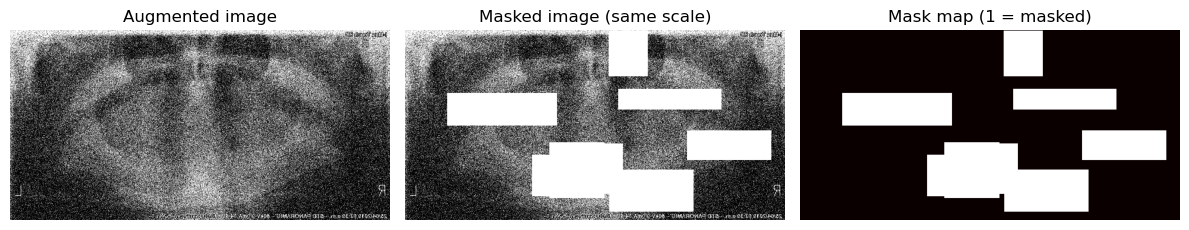


=== Sample 1 ===
Image path : E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\images\A_L_002.png
age_group  : adult
label_status: labeled
range target : -1.9993849992752075 -> -1.9843138456344604
range masked : -1.9993849992752075 -> -0.0
range mask   : 0.0 -> 1.0


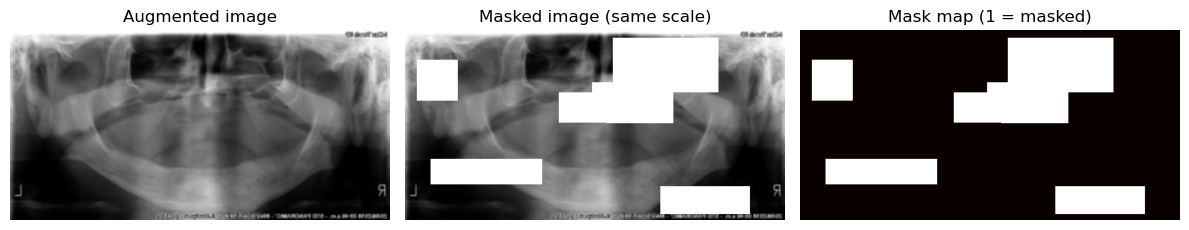


=== Sample 2 ===
Image path : E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\images\A_L_003.png
age_group  : adult
label_status: labeled
range target : -1.9991389513015747 -> -1.9843138456344604
range masked : -1.9991389513015747 -> -0.0
range mask   : 0.0 -> 1.0


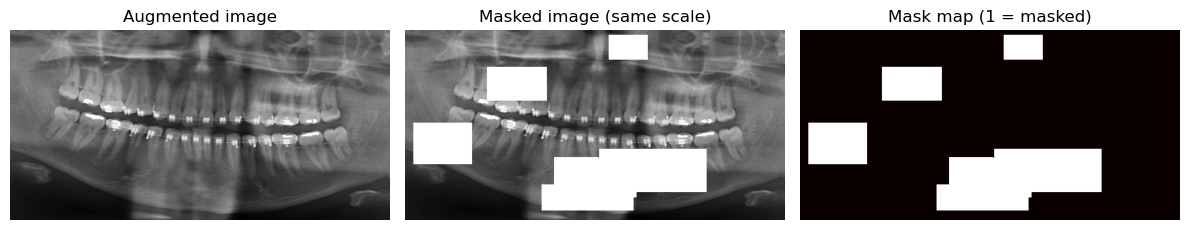

In [9]:
# ## 7. Sanity check: visualize MIM masking
#
# We sample a few images from the dataset and visualize:
# - Original augmented image
# - Masked image (same intensity scale as target)
# - Mask map
# %%
mim_dataset = DentalMIMReconstructionDataset(
    df_pretrain=df_pretrain,
    transform=mim_transform,
    num_blocks=8,
    min_block_fraction=0.1,
    max_block_fraction=0.3,
)

print("Number of MIM samples:", len(mim_dataset))

# Visualize a few samples
NUM_VIS_SAMPLES = 3

for i in range(NUM_VIS_SAMPLES):
    masked_img, target_img, mask_tensor, meta = mim_dataset[i]

    # Convert to numpy for visualization
    # target_img: (1, H, W)
    target_np = target_img.squeeze(0).cpu().numpy()
    masked_np = masked_img.squeeze(0).cpu().numpy()
    mask_np   = mask_tensor.squeeze(0).cpu().numpy()

    print("\n=== Sample", i, "===")
    print("Image path :", meta["img_path"])
    print("age_group  :", meta["age_group"])
    print("label_status:", meta["label_status"])
    print("range target :", float(target_np.min()), "->", float(target_np.max()))
    print("range masked :", float(masked_np.min()), "->", float(masked_np.max()))
    print("range mask   :", float(mask_np.min()),   "->", float(mask_np.max()))

    # Use the same intensity range for target and masked image
    vmin, vmax = target_np.min(), target_np.max()

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(target_np, cmap="gray")
    axes[0].set_title("Augmented image")
    axes[0].axis("off")

    axes[1].imshow(masked_np, cmap="gray", vmin=vmin, vmax=vmax)
    axes[1].set_title("Masked image (same scale)")
    axes[1].axis("off")

    axes[2].imshow(mask_np, cmap="hot", vmin=0, vmax=1)
    axes[2].set_title("Mask map (1 = masked)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


In [10]:
# ## 8. 2D U-Net model definition
#
# We implement a standard 2D U-Net:
# - Encoder: four levels with downsampling by factor 2 at each level.
# - Decoder: four upsampling levels with skip connections.
# - Input:  1-channel grayscale image (1, 320, 640).
# - Output: 1-channel reconstruction (1, 320, 640).
#
# This model will be pretrained with a masked reconstruction objective
# and later reused as a backbone for tooth segmentation.

# %%
class DoubleConv(nn.Module):
    """(Conv2d -> BN -> ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if mid_channels is None:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with MaxPool then DoubleConv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        return self.block(x)


class Up(nn.Module):
    """Upscaling then DoubleConv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if use bilinear upsampling, reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # x1: from previous decoder level
        # x2: from encoder skip connection
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        # pad x1 to have the same size as x2 if needed
        x1 = nn.functional.pad(
            x1,
            [diffX // 2, diffX - diffX // 2,
             diffY // 2, diffY - diffY // 2],
        )

        # concatenate along channels
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    """Final 1x1 convolution to produce output channels"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet2D(nn.Module):
    """
    2D U-Net backbone for MIM pretraining.

    - in_channels:  1 (grayscale)
    - out_channels: 1 (reconstructed grayscale)
    """

    def __init__(self, in_channels=1, out_channels=1, base_channels=32, bilinear=True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bilinear = bilinear

        self.inc = DoubleConv(in_channels, base_channels)
        self.down1 = Down(base_channels, base_channels * 2)
        self.down2 = Down(base_channels * 2, base_channels * 4)
        self.down3 = Down(base_channels * 4, base_channels * 8)
        self.down4 = Down(base_channels * 8, base_channels * 8)

        self.up1 = Up(base_channels * 16, base_channels * 4, bilinear)
        self.up2 = Up(base_channels * 8, base_channels * 2, bilinear)
        self.up3 = Up(base_channels * 4, base_channels, bilinear)
        self.up4 = Up(base_channels * 2, base_channels, bilinear)

        self.outc = OutConv(base_channels, out_channels)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)      # (B, C, H, W)
        x2 = self.down1(x1)   # (B, 2C, H/2, W/2)
        x3 = self.down2(x2)   # (B, 4C, H/4, W/4)
        x4 = self.down3(x3)   # (B, 8C, H/8, W/8)
        x5 = self.down4(x4)   # (B, 8C, H/16, W/16)

        # Decoder with skip connections
        x = self.up1(x5, x4)  # (B, 4C, H/8,  W/8)
        x = self.up2(x,  x3)  # (B, 2C, H/4,  W/4)
        x = self.up3(x,  x2)  # (B, C,  H/2,  W/2)
        x = self.up4(x,  x1)  # (B, C,  H,    W)

        logits = self.outc(x) # (B, out_channels, H, W)
        return logits


# Instantiate model
model = UNet2D(in_channels=1, out_channels=1, base_channels=32, bilinear=True)
model = model.to(device)
print(model)



UNet2D(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (block): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          

In [11]:
# ## 9. DataLoader and MIM loss
#
# - We build a DataLoader on top of `DentalMIMReconstructionDataset`.
# - Loss: L1 reconstruction loss *on masked pixels only*:
#     loss = mean( |pred - target| over masked regions )
#
# This is one simple version of MIM-style training. You can later experiment
# with other losses (L2, SSIM, perceptual loss, etc.).


# %%
BATCH_SIZE = 4
NUM_WORKERS = 0  # adjust depending on your machine

mim_dataset = DentalMIMReconstructionDataset(
    df_pretrain=df_pretrain,
    transform=mim_transform,
    num_blocks=8,
    min_block_fraction=0.1,
    max_block_fraction=0.3,
)

mim_loader = DataLoader(
    mim_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda"),
)

print("MIM DataLoader is ready. Batches:", len(mim_loader))


def masked_l1_loss(pred: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    """
    Compute L1 loss on masked pixels only.

    Args:
        pred:   (B, 1, H, W)
        target: (B, 1, H, W)
        mask:   (B, 1, H, W) in {0,1}, where 1 = masked pixel

    Returns:
        scalar loss
    """
    # element-wise L1
    l1 = torch.abs(pred - target)  # (B, 1, H, W)

    # focus only on masked positions
    masked_l1 = l1 * mask

    # avoid division by zero if mask is empty
    denom = mask.sum()
    if denom.item() < 1.0:
        # fallback: full-image loss
        return l1.mean()

    loss = masked_l1.sum() / denom
    return loss




MIM DataLoader is ready. Batches: 1000


In [12]:
# ## 10. Training hyperparameters and optimizer
#
# - Optimizer: Adam
# - Learning rate: 1e-3 (you can tune this)
# - Epochs: start small (e.g. 20) for a first run
#
# You can later increase the number of epochs if loss keeps decreasing.
# %%
LR = 1e-3
NUM_EPOCHS = 20  # adjust based on your GPU / patience

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
print("Optimizer:", optimizer)


Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [13]:
# %% 11. MIM pretraining loop with tqdm
from tqdm.auto import tqdm

model.train()

for epoch in range(1, NUM_EPOCHS + 1):
    running_loss = 0.0
    num_batches = 0

    # 用 tqdm 包一层 dataloader，可以看到每个 batch 的进度和当前 loss
    pbar = tqdm(mim_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}", leave=True)

    for batch in pbar:
        masked_img, target_img, mask_tensor, meta = batch
        # masked_img, target_img, mask_tensor: (B, 1, H, W)

        masked_img = masked_img.to(device)
        target_img = target_img.to(device)
        mask_tensor = mask_tensor.to(device)

        optimizer.zero_grad()

        # Forward
        pred = model(masked_img)  # (B, 1, H, W)

        # Loss on masked pixels
        loss = masked_l1_loss(pred, target_img, mask_tensor)

        # Backward
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_batches += 1

        # 在进度条上显示当前 batch loss
        pbar.set_postfix({"batch_loss": loss.item()})

    avg_loss = running_loss / max(1, num_batches)
    print(f"Epoch [{epoch:02d}/{NUM_EPOCHS}] - Avg MIM loss: {avg_loss:.6f}")

# save the weights
SAVE_DIR = DATA_ROOT / "checkpoints"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

save_path = SAVE_DIR / "unet2d_mim_pretrained.pth"
torch.save(model.state_dict(), save_path)

print("Pretrained U-Net weights saved to:", save_path)

Epoch 1/20:   5%|▍         | 47/1000 [00:09<03:19,  4.77it/s, batch_loss=0.025] 


KeyboardInterrupt: 

In [ ]:

# ## 12. (Optional) Quick reconstruction preview
#
# Let's visually inspect how well the pretrained U-Net reconstructs masked images:
# - Take a few validation samples from `mim_dataset`
# - Feed masked images into the model
# - Compare prediction vs target
# %%
model.eval()

NUM_PREVIEW = 3
with torch.no_grad():
    for i in range(NUM_PREVIEW):
        masked_img, target_img, mask_tensor, meta = mim_dataset[i]

        masked_img_b = masked_img.unsqueeze(0).to(device)  # (1, 1, H, W)
        pred_b = model(masked_img_b)
        pred_img = pred_b.squeeze(0).squeeze(0).cpu().numpy()
        target_np = target_img.squeeze(0).cpu().numpy()
        masked_np = masked_img.squeeze(0).cpu().numpy()
        mask_np = mask_tensor.squeeze(0).cpu().numpy()

        print("\n=== Reconstruction preview sample", i, "===")
        print("Image path :", meta["img_path"])
        print("age_group  :", meta["age_group"])
        print("label_status:", meta["label_status"])

        fig, axes = plt.subplots(1, 4, figsize=(16, 4))

        axes[0].imshow(target_np, cmap="gray")
        axes[0].set_title("Target (augmented)")
        axes[0].axis("off")

        axes[1].imshow(masked_np, cmap="gray")
        axes[1].set_title("Masked input")
        axes[1].axis("off")

        axes[2].imshow(pred_img, cmap="gray")
        axes[2].set_title("Reconstruction")
        axes[2].axis("off")

        axes[3].imshow(mask_np, cmap="hot")
        axes[3].set_title("Mask")
        axes[3].axis("off")

        plt.tight_layout()
        plt.show()
